In [1]:
import pandas as pd
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from scipy.stats import pearsonr, spearmanr
from scipy import stats

import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
# This function connects to the Codeup database.
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
# This function fetches the specified data and stores it as a Pandas dataframe
def zillow_sql():
    '''
    This function reads the zillow data from the Codeup database into a Pandas dataframe.
    '''
    sql_query = """
                SELECT * FROM predictions_2017
                left join properties_2017 using(parcelid)
                where properties_2017.propertylandusetypeid = 261;
                """
    
    # Read in DataFrame from Codeup db.
    zillow_df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return zillow_df

# This function caches the zillow data.

def get_zillow_data():
    '''
    This function reads in zillow data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow.csv'):
        
        # If csv file exists read in data from csv file.
        zillow_df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        zillow_df = zillow_sql()
        
        # Cache data
        zillow_df.to_csv('zillow.csv')
        
    return zillow_df

# Project Objectives:
#### * Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook Final Report.

#### * Create modules (acquire.py, prepare.py) that make your process repeateable and your report (notebook) easier to read and follow.

#### * Ask exploratory questions of your data that will help you understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.

#### * Construct a model to predict assessed home value for single family properties using regression techniques.

#### * Make recommendations to a data science team about how to improve predictions.

#### * Refine your work into a Report, in the form of a jupyter notebook, that you will walk through in a 5 minute presentation to a group of collegues and managers about the work you did, why, goals, what you found, your methdologies, and your conclusions.

#### * Be prepared to answer panel questions about your code, process, findings and key takeaways, and model.

# Target: predict property tax assessed values ('taxvaluedollarcnt') of Single Family Properties 

## * Ask exploratory questions of your data that will help you understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.

#### Which columns seem like it would be interesting if there was a correlation?

In [ ]:
# These would be interesting features to investigate.
interesting = ['latitude', 'longitude', 'regionidcity', 'retionidcounty', 'regionidzip']

#### Which columns or attributes should influence the target?

In [ ]:
# These are the features you would expect to influence the pricing of a house.
expected_features = ['architecturalstyletypeid', 'airconditioningtypeid', 'buildingclasstypeid', 'heatingorsystemtypeid', 'storytypeid', 'typeconstructiontypeid']

In [3]:
# Store the zillow data as a Pandas dataframe.
zillow_df = get_zillow_data()

In [ ]:
# Make an 'incaseshithappens' copy of the dataframe.
original_zillow_df_copy = zillow_df

In [ ]:
original_zillow_df_copy

In [4]:
zillow_df.head()

,parcelid,id,logerror,transactiondate,id.1,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,14297519,0,0.025595,2017-01-01,1727539,NaN,NaN,NaN,3.5,4.0,...,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13
1,17052889,1,0.055619,2017-01-01,1387261,NaN,NaN,NaN,1.0,2.0,...,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13
2,14186244,2,0.005383,2017-01-01,11677,NaN,NaN,NaN,2.0,3.0,...,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13
3,12177905,3,-0.103410,2017-01-01,2288172,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13
4,12095076,6,-0.001011,2017-01-01,781532,1.0,NaN,NaN,3.0,4.0,...,NaN,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13


In [5]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   id                            52442 non-null  int64  
 2   logerror                      52442 non-null  float64
 3   transactiondate               52442 non-null  object 
 4   id.1                          52442 non-null  int64  
 5   airconditioningtypeid         13638 non-null  float64
 6   architecturalstyletypeid      70 non-null     float64
 7   basementsqft                  47 non-null     float64
 8   bathroomcnt                   52442 non-null  float64
 9   bedroomcnt                    52442 non-null  float64
 10  buildingclasstypeid           0 non-null      float64
 11  buildingqualitytypeid         33741 non-null  float64
 12  calculatedbathnbr             52305 non-null  float64
 13  d

In [6]:
zillow_df.isnull().sum()

parcelid                     0
id                           0
logerror                     0
transactiondate              0
id.1                         0
                         ...  
landtaxvaluedollarcnt        1
taxamount                    4
taxdelinquencyflag       50363
taxdelinquencyyear       50363
censustractandblock        123
Length: 62, dtype: int64

In [ ]:
# Make a list of columns to drop:

drop_columns = ['architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'basementsqft', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertyzoningdesc', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxamount', 'taxdelinquencyflag', 'taxdelinquencyyear']

In [7]:
# Use these features for the 'MVP' model.
orig_draft_features = ['landtaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 'fips']

In [8]:
orig_draft_features = zillow_df[orig_draft_features]

In [9]:
orig_draft_features.isnull().sum()

landtaxvaluedollarcnt            1
calculatedfinishedsquarefeet    82
bedroomcnt                       0
bathroomcnt                      0
fips                             0
dtype: int64

### Visualizing Distributions & Outliers

In [10]:
# Renaming columns to make referencing easier.
orig_draft_features = orig_draft_features.rename(columns = {'landtaxvaluedollarcnt':'tax_value', 'calculatedfinishedsquarefeet':'sqft','bedroomcnt':'bedrooms','bathroomcnt':'bathrooms'})

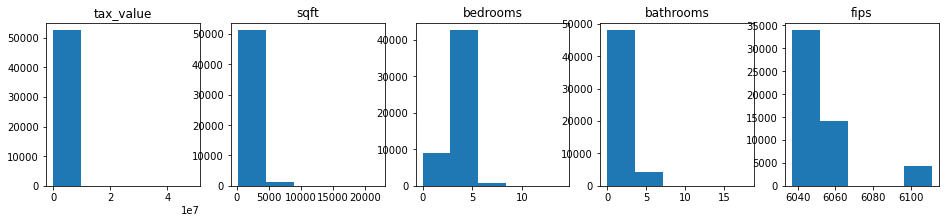

In [11]:
# Visualize the distributions of the features.
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in orig_draft_features.columns]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    orig_draft_features[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
plt.show()

#### Takeaways

* Significant square footage outliers exist.
* Similar outliers exist within the bedrooms and bathrooms columns.

<AxesSubplot:>

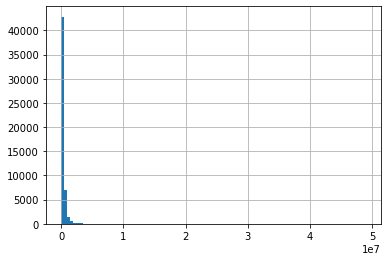

In [12]:
# Looking at tax_value in closer detail
orig_draft_features['tax_value'].hist(bins=100)

### Boxplots

Boxplots are useful because they will naturally show outliers as black diamonds on the diagram.

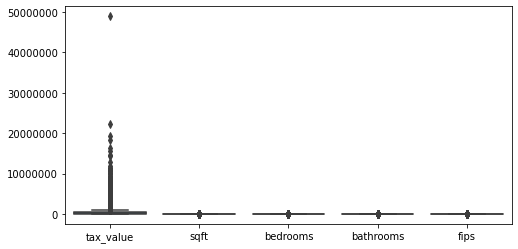

In [13]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=orig_draft_features)

plt.show()

### Takeaway

* The tax value has such a severe outlier problem, it is making the chart unreadable.

* I will try to make the charts bigger to see if visualization improves.

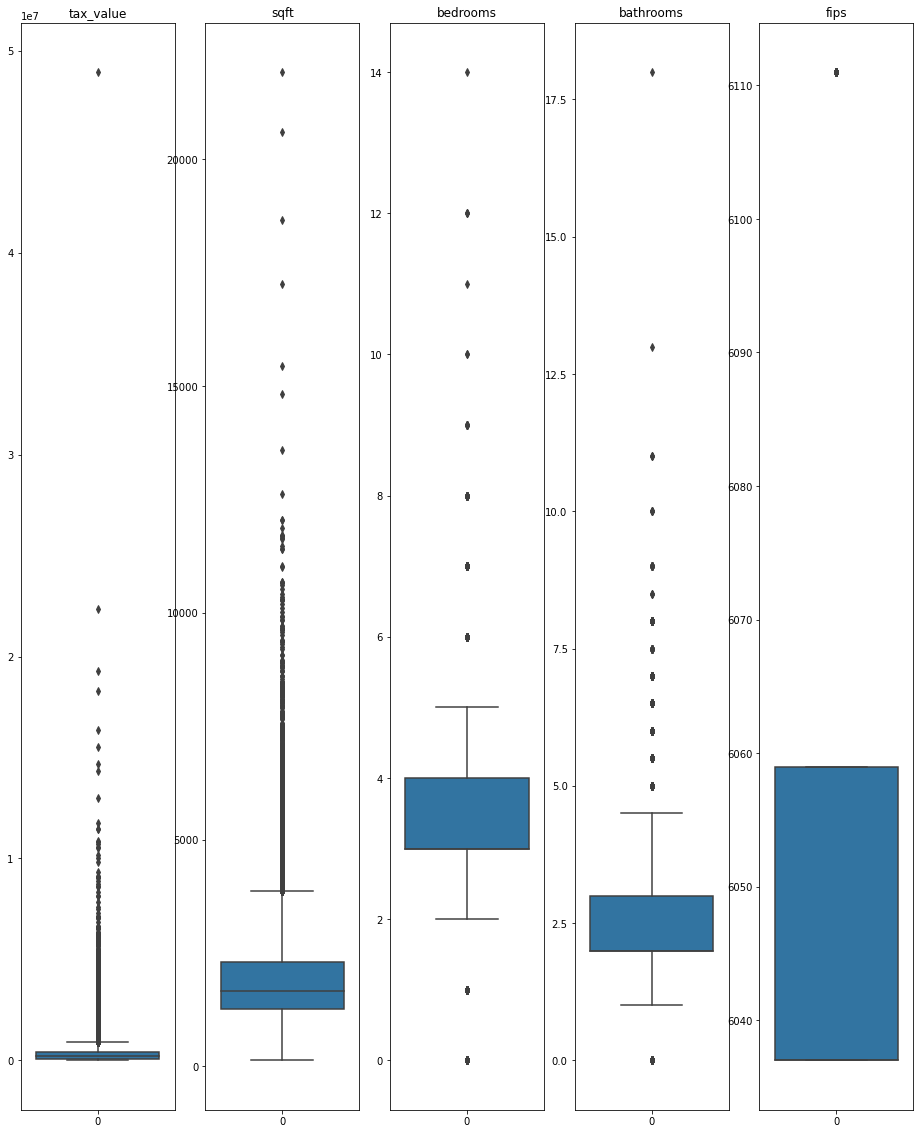

In [14]:
# List of columns
cols = [col for col in orig_draft_features.columns]
# Set the figures to a larger size.
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=orig_draft_features[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

What are the quartiles for these columns?

In [15]:
orig_draft_features.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,tax_value,sqft,bedrooms,bathrooms,fips
count,52441,52360,52442,52442,52442
mean,333463,1922.87,3.30068,2.2994,6049.13
std,570523,1004.36,0.949086,1.02276,21.0289
min,161,128,0,0,6037
25%,76026,1268,3,2,6037
50%,218025,1659,3,2,6037
75%,408600,2306,4,3,6059
max,4.89522e+07,21929,14,18,6111


### Takeaways

* Too many outliers.
* The MVP will focus on home values closer to the median so it will be okay to remove high value homes.
* Removing these records may also help to reduce the amount of null values we have.

In [16]:
# This function removes outliers.
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [17]:
# Run the function and store results in a variable.
orig_draft_features = remove_outliers(orig_draft_features, 1.5, ['tax_value', 'sqft', 'bedrooms', 'bathrooms'])

### Revisualize Distributions

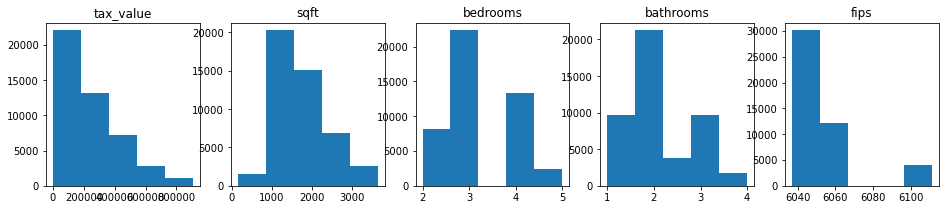

In [18]:
# After removing outliers replot the distributions.

plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in orig_draft_features.columns]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    orig_draft_features[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
plt.show()

### Takeaways

* Tax_value is right skewed.
* Bedrooms and bathrooms are not normally distributed.
* Square footage is approaching a normal distrubtion.

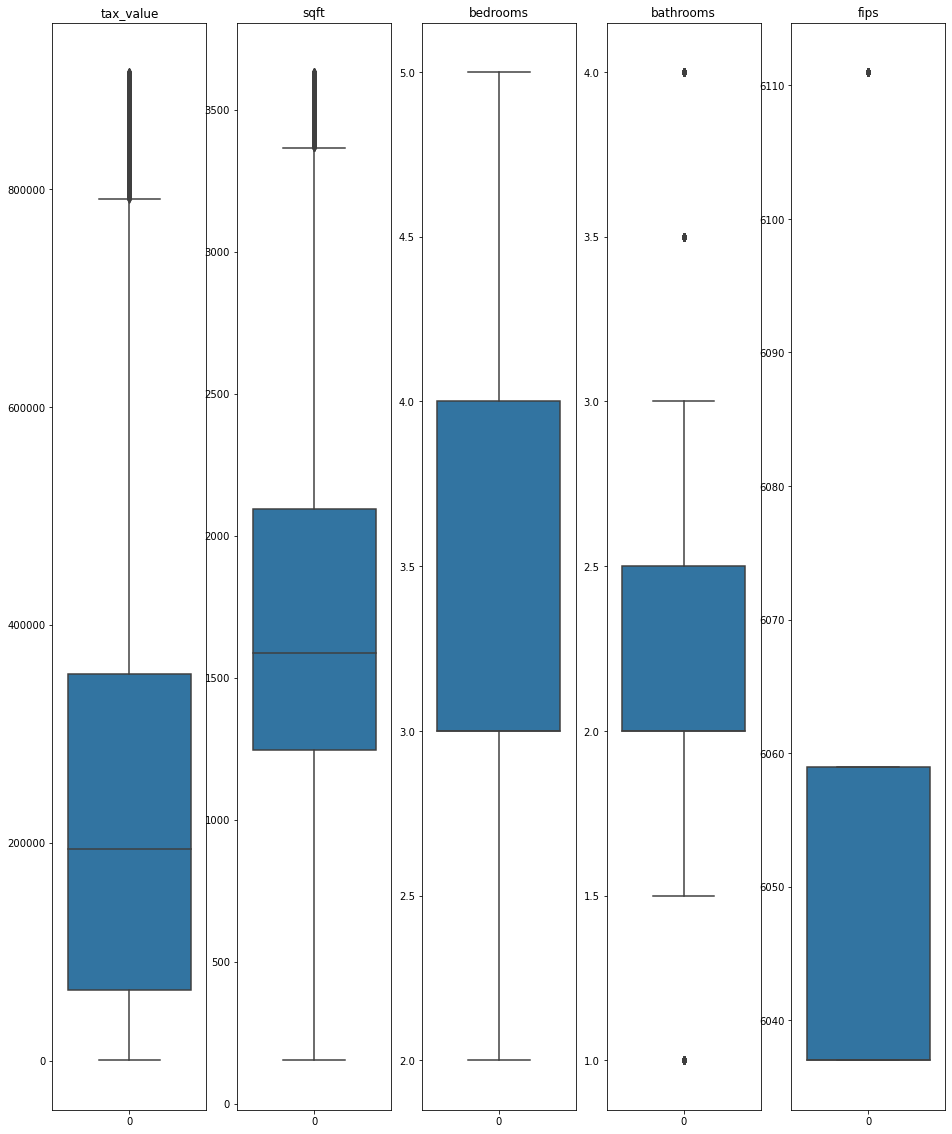

In [19]:
# View boxplots.
cols = [col for col in orig_draft_features.columns]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=orig_draft_features[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

### Takeaways

* Still a few outliers despite the relatively restrictive 1.5 * IQR setting for the upper/lower boundary.
* No need to remove these outliers.

### How do the null values look now?

In [20]:
orig_draft_features.isnull().sum()

tax_value    0
sqft         0
bedrooms     0
bathrooms    0
fips         0
dtype: int64

### Are the column data types correct?

In [21]:
orig_draft_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46249 entries, 0 to 52441
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tax_value  46249 non-null  float64
 1   sqft       46249 non-null  float64
 2   bedrooms   46249 non-null  float64
 3   bathrooms  46249 non-null  float64
 4   fips       46249 non-null  float64
dtypes: float64(5)
memory usage: 3.1 MB


### Split the data

In [22]:
train_validate, test = train_test_split(orig_draft_features, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [23]:
train.info(), validate.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25899 entries, 15182 to 46431
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tax_value  25899 non-null  float64
 1   sqft       25899 non-null  float64
 2   bedrooms   25899 non-null  float64
 3   bathrooms  25899 non-null  float64
 4   fips       25899 non-null  float64
dtypes: float64(5)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11100 entries, 34265 to 12047
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tax_value  11100 non-null  float64
 1   sqft       11100 non-null  float64
 2   bedrooms   11100 non-null  float64
 3   bathrooms  11100 non-null  float64
 4   fips       11100 non-null  float64
dtypes: float64(5)
memory usage: 520.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9250 entries, 51871 to 40978
Data columns (total 5 columns):
 #   Column     Non-Nul

(None, None, None)

### Use the 'Min-Max Scaler' to scale the independent variables.

In [27]:
# 1. create the object
scaler = sklearn.preprocessing.MinMaxScaler()

# 2. fit the object (learn the min and max value)
scaler.fit(train[['sqft', 'bedrooms', 'bathrooms', 'fips']])

# 3. use the object (use the min, max to do the transformation)
scaled_features = scaler.transform(train[['sqft', 'bedrooms', 'bathrooms', 'fips']])

In [28]:
# assign the scaled values as new columns in the train
train[['sqft_scaled', 'bedrooms_scaled', 'bathrooms_scaled', 'fips']] = scaled_features

In [29]:
train.head()

,tax_value,sqft,bedrooms,bathrooms,fips,sqft_scaled,bedrooms_scaled,bathrooms_scaled
15182,131568.0,1833.0,4.0,3.0,0.000000,0.431280,0.666667,0.666667
39226,66939.0,932.0,3.0,1.0,1.000000,0.146603,0.333333,0.000000
32538,82541.0,864.0,2.0,1.0,0.000000,0.125118,0.000000,0.000000
8521,19279.0,960.0,3.0,1.0,0.297297,0.155450,0.333333,0.000000
7399,31870.0,1050.0,3.0,2.0,0.000000,0.183886,0.333333,0.333333


In [32]:
validate.head()

,tax_value,sqft,bedrooms,bathrooms,fips,sqft_scaled,bedrooms_scaled,bathrooms_scaled
34265,306199.0,2042.0,4.0,3.0,0.000000,0.497314,0.666667,0.666667
19371,605327.0,2307.0,5.0,3.5,0.297297,0.581043,1.000000,0.833333
26479,213267.0,2284.0,4.0,2.5,1.000000,0.573776,0.666667,0.500000
14117,236101.0,652.0,2.0,1.0,0.000000,0.058136,0.000000,0.000000
47302,281321.0,1911.0,3.0,2.0,0.000000,0.455924,0.333333,0.333333


In [31]:
# make new scaled columns for validate and test (transform only)

test[['sqft_scaled', 'bedrooms_scaled', 'bathrooms_scaled', 'fips']] = scaler.transform(test[['sqft', 'bedrooms', 'bathrooms', 'fips']])
validate[['sqft_scaled', 'bedrooms_scaled', 'bathrooms_scaled', 'fips']] = scaler.transform(validate[['sqft', 'bedrooms', 'bathrooms', 'fips']])

### Implementation

In [ ]:
def add_scaled_columns(train, validate, test, scaler, columns_to_scale):
    
    # new column names
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    # Fit the scaler on the train
    scaler.fit(train[columns_to_scale])
    
    # transform train validate and test
    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    
    
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    return train, validate, test

### Can I predict the land tax value of a home based on square footage?

x = square footage
y = tax value

## Look at scatter of square footage vs tax value

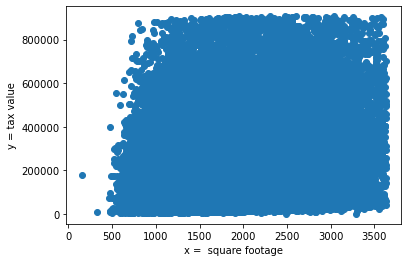

In [35]:
plt.scatter(orig_draft_features.sqft, orig_draft_features.tax_value)
plt.xlabel('x =  square footage')
plt.ylabel('y = tax value');

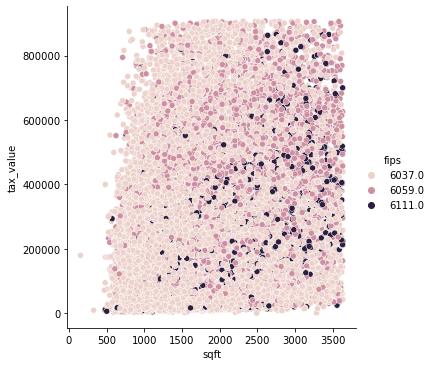

In [95]:
sns.relplot(x='sqft', y='tax_value', hue='fips', data=orig_draft_features)

### Create a baseline prediction.

In [40]:
baseline = orig_draft_features.tax_value.mean()

In [41]:
# My baseline is the mean of tax_value
orig_draft_features['baseline'] = baseline

In [42]:
orig_draft_features.head()

,tax_value,sqft,bedrooms,bathrooms,fips,baseline
0,537569.0,3100.0,4.0,3.5,6059.0,236754.126857
1,376000.0,1465.0,2.0,1.0,6111.0,236754.126857
2,479489.0,1243.0,3.0,2.0,6059.0,236754.126857
3,36225.0,2376.0,4.0,3.0,6037.0,236754.126857
4,496619.0,2962.0,4.0,3.0,6037.0,236754.126857


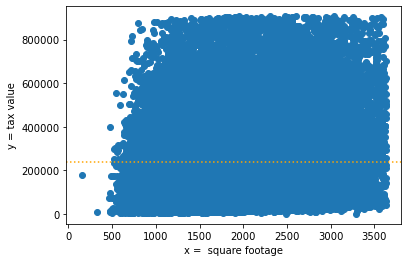

In [43]:
# plot data with baseline:

plt.scatter(orig_draft_features.sqft, orig_draft_features.tax_value)
plt.axhline(baseline, ls = ':', color='orange')
plt.xlabel('x =  square footage')
plt.ylabel('y = tax value');

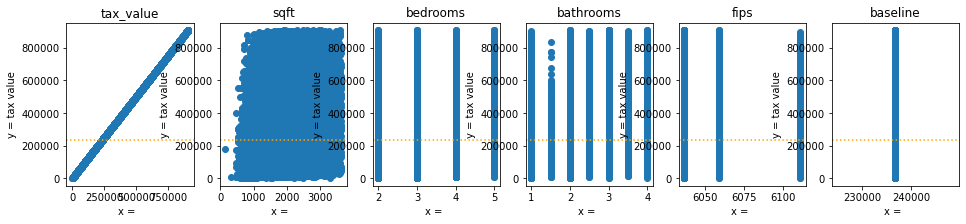

In [44]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in orig_draft_features.columns]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display scatterplot for column.
    plt.scatter(orig_draft_features[col], orig_draft_features.tax_value)
    plt.axhline(baseline, ls = ':', color='orange')
    plt.xlabel('x =  ')
    plt.ylabel('y = tax value');

    # Hide gridlines.
    plt.grid(False)
    
plt.show()

In [45]:
target = "tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns=[target])
y_test = test[target]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25899 entries, 15182 to 46431
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sqft              25899 non-null  float64
 1   bedrooms          25899 non-null  float64
 2   bathrooms         25899 non-null  float64
 3   fips              25899 non-null  float64
 4   sqft_scaled       25899 non-null  float64
 5   bedrooms_scaled   25899 non-null  float64
 6   bathrooms_scaled  25899 non-null  float64
dtypes: float64(7)
memory usage: 1.6 MB


In [46]:
X_train_scaled = X_train.drop(columns=['sqft','bedrooms','bathrooms'])
X_validate_scaled = X_validate.drop(columns=['sqft','bedrooms','bathrooms'])
X_test_scaled = X_test.drop(columns=['sqft','bedrooms','bathrooms'])

In [47]:
X_test_scaled

,fips,sqft_scaled,bedrooms_scaled,bathrooms_scaled
51871,0.000000,0.497630,0.666667,0.666667
50493,1.000000,0.786730,0.666667,0.666667
3217,0.000000,0.467615,0.333333,0.000000
37283,0.000000,0.655292,0.333333,0.666667
46224,0.297297,0.399052,0.333333,0.333333
...,...,...,...,...
5001,0.000000,0.184834,0.000000,0.000000
14756,0.000000,0.260979,0.333333,0.333333
25112,0.000000,0.329858,1.000000,0.333333
24068,0.000000,0.421169,0.666667,0.666667


In [48]:
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings("ignore")

In [49]:
# Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

def select_kbest(X, y, k):
    # make the object
    kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=k)

    # fit the object
    kbest.fit(X, y)
    
    # use the object (.get_support() is that array of booleans to filter the list of column names)
    return X.columns[kbest.get_support()].tolist()

In [50]:
# Find the top 2 features using kbest
select_kbest(X_train_scaled, y_train, 2)

['sqft_scaled', 'bathrooms_scaled']

In [51]:
def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    # rfe here is reference rfe from cell 15
    var_ranks = rfe.ranking_
    var_names = X_train.columns.tolist()
    ranks = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    ranks = ranks.sort_values(by="Rank", ascending=True)
    return ranks

In [52]:
# Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. 

def select_rfe(X, y, k):
    # make the thing
    lm = sklearn.linear_model.LinearRegression()
    rfe = sklearn.feature_selection.RFE(lm, n_features_to_select=k)

    # Fit the thing
    rfe.fit(X, y)
    
    # use the thing
    features_to_use = X.columns[rfe.support_].tolist()
    
    # we need to send show_feature_rankings a trained/fit RFE object
    all_rankings = show_features_rankings(X, rfe)
    
    return features_to_use, all_rankings

In [53]:
select_rfe(X_train_scaled, y_train, 2)

(['sqft_scaled', 'bedrooms_scaled'],
                 Var  Rank
 1       sqft_scaled     1
 2   bedrooms_scaled     1
 3  bathrooms_scaled     2
 0              fips     3)

In [54]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [100]:
# 1. Predict tax_value mean
tax_value_mean = baseline
y_train['tax_value_mean'] = baseline
y_validate['tax_value_mean'] = baseline
y_test['tax_value_mean'] = baseline

In [56]:
# 2. compute tax_value median
tax_value_median = y_train.tax_value.median()
y_train['tax_value_median'] = tax_value_median
y_validate['tax_value_median'] = tax_value_median

In [57]:
# 3. RMSE of tax_value_mean
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.tax_value_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_mean) ** (0.5)

In [101]:
rmse_test_baseline = mean_squared_error(y_test, y_test.tax_value_mean) ** (0.5)

ValueError: y_true and y_pred have different number of output (2!=1)

In [58]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  196627.76 
Validate/Out-of-Sample:  197242.4


In [59]:
# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_median) ** (0.5)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  201290.34 
Validate/Out-of-Sample:  201823.52


### Build a dataframe for comparison of our metrics for model selection for ease of reflection.


In [60]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [61]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201290.338154,201823.516231


In [62]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25899 entries, 15182 to 46431
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tax_value         25899 non-null  float64
 1   tax_value_mean    25899 non-null  float64
 2   tax_value_median  25899 non-null  float64
dtypes: float64(3)
memory usage: 809.3 KB


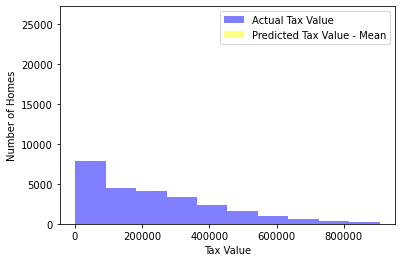

In [63]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.tax_value_mean, color='yellow', alpha=.5, label="Predicted Tax Value - Mean")
# plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5, label="Predicted Final Grades - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

### LinearRegression (OLS)

Fit the model using X_train (scaled) and the labels from y_train.

Predict tax value for homes in training sample using our model (lm).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [64]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25899 entries, 15182 to 46431
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fips              25899 non-null  float64
 1   sqft_scaled       25899 non-null  float64
 2   bedrooms_scaled   25899 non-null  float64
 3   bathrooms_scaled  25899 non-null  float64
dtypes: float64(4)
memory usage: 1011.7 KB


In [65]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25899 entries, 15182 to 46431
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tax_value         25899 non-null  float64
 1   tax_value_mean    25899 non-null  float64
 2   tax_value_median  25899 non-null  float64
dtypes: float64(3)
memory usage: 809.3 KB


In [66]:
# create the model object

# make the thing

lm = LinearRegression()

In [67]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train_scaled, y_train.tax_value)

LinearRegression()

In [68]:
# predict train
# 
# use the thing!
# 
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

In [69]:
y_train.head()

,tax_value,tax_value_mean,tax_value_median,tax_value_pred_lm
15182,131568.0,236754.126857,193955.0,225896.813248
39226,66939.0,236754.126857,193955.0,183690.782439
32538,82541.0,236754.126857,193955.0,177120.265617
8521,19279.0,236754.126857,193955.0,162519.044839
7399,31870.0,236754.126857,193955.0,172856.063640


In [102]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  188132.01068817743 
Validation/Out-of-Sample:  189757.7356057491


In [71]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [72]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201290.338154,201823.516231
1,OLS Regressor,188132.010688,189757.735606


### LassoLars

Fit the model using X_train (scaled) and the labels from y_train.

Predict tax value for homes in training sample using our model (lars).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [73]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  188132.47192823558 
Validation/Out-of-Sample:  189750.9400108173 
Difference:  1618.468082581734


In [ ]:
lars.coef_

In [74]:
metric_df = metric_df.append({
    'model': 'lasso_alpha0.1', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [75]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201290.338154,201823.516231
1,OLS Regressor,188132.010688,189757.735606
2,lasso_alpha0.1,188132.471928,189750.940011


### TweedieRegressor (GLM)

Fit the model using X_train (scaled) and the labels from y_train.

Predict tax value for homes in training sample using our model (glm).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [76]:
from sklearn.linear_model import TweedieRegressor

<AxesSubplot:>

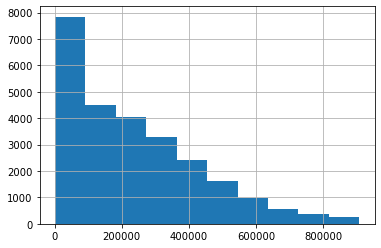

In [77]:
y_train.tax_value.hist()

In [78]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  188081.44909962072 
Validation/Out-of-Sample:  189823.24368719553


In [79]:
metric_df = metric_df.append({
    'model': 'glm_poisson', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [80]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201290.338154,201823.516231
1,OLS Regressor,188132.010688,189757.735606
2,lasso_alpha0.1,188132.471928,189750.940011
3,glm_poisson,188081.449100,189823.243687


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

Create the new features, based on value indicated for degree for train, validate & test.

Fit the Linear Regression model

Predict using the transformed (squared or cubed, e.g.) features

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [81]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)

In [82]:
X_train_degree2.shape

(25899, 15)

### LinearRegression

In [83]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  185318.4007114134 
Validation/Out-of-Sample:  187841.3041592155


In [84]:
metric_df = metric_df.append({
    'model': 'quadratic', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [85]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,201290.338154,201823.516231
1,OLS Regressor,188132.010688,189757.735606
2,lasso_alpha0.1,188132.471928,189750.940011
3,glm_poisson,188081.449100,189823.243687
4,quadratic,185318.400711,187841.304159


### Evaluate

#### Plotting Actual vs. Predicted Values

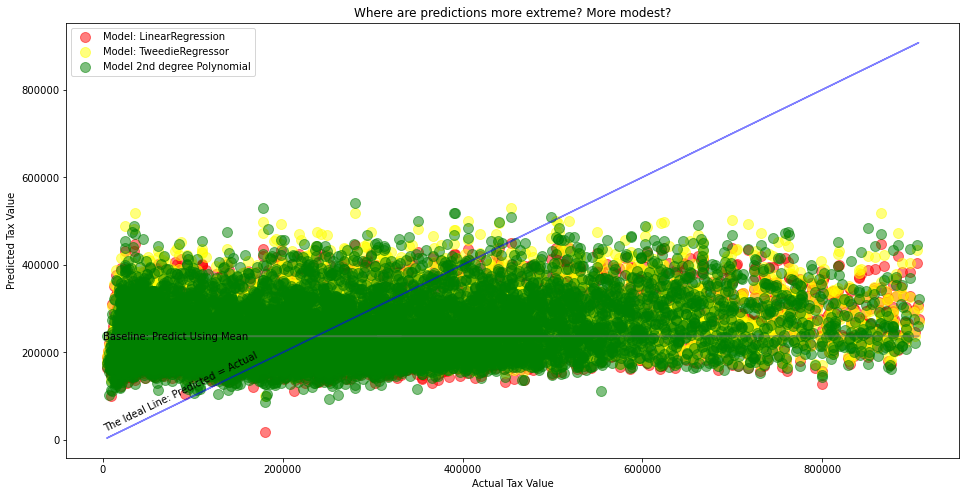

In [87]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 230000))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (10, 20000), rotation=26)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Takeaways

* The Linear Regression model is good at predicting tax values from the 100,000 to 350,000 range.
* The two other models have similar predictions.

#### Residual Plots: Plotting the Errors in Predictions

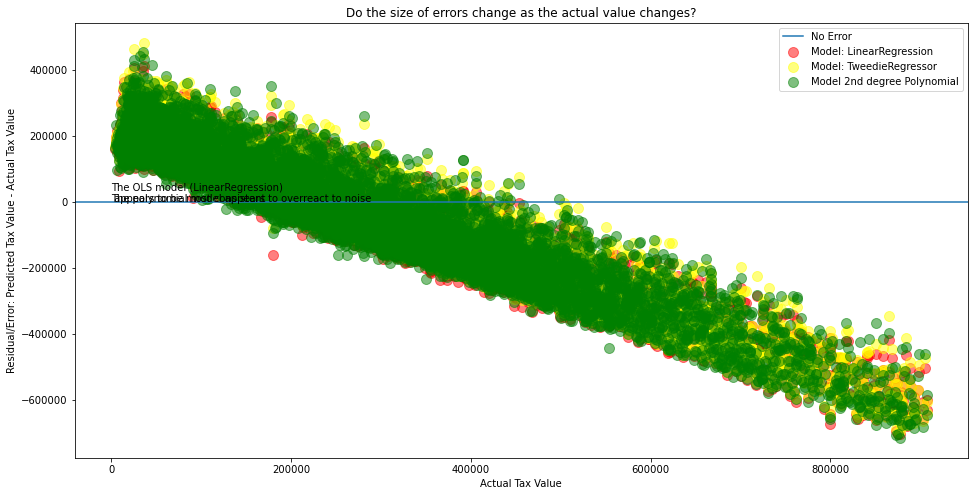

In [88]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Takeaway
* My models get a better prediction from the 150,000 to 300,000 range.
* These models overvalues cheaper homes and undervalues more expensive homes.

### Histograms

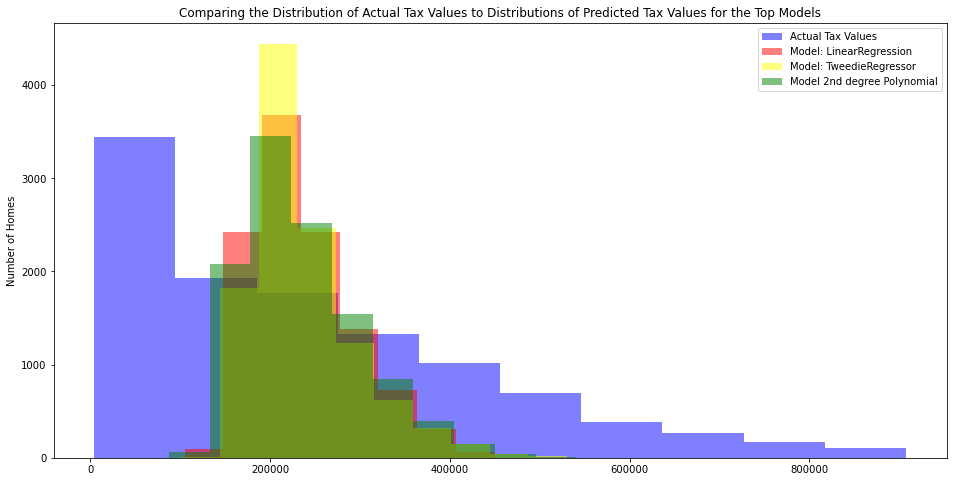

In [89]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
# plt.xlabel("Tax Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

### Takeaways

* The models predict tax values from the 100000 to the 400000 range.
* The models are overpredicting the amount of 200000-250000 dollar homes.

### Going with the OLS model to use on the test set.

In [90]:
# predict test
# 
# use the thing!
# 
y_test_predictions = lm.predict(X_test_scaled)

In [92]:
rmse_test

187977.90459592952

In [93]:
metric_df = metric_df.append({
    'model': 'Best Model(OLS)', 
    'RMSE_test': rmse_test
    }, ignore_index=True)

In [94]:
metric_df

,model,RMSE_train,RMSE_validate,RMSE_test
0,mean_baseline,201290.338154,201823.516231,NaN
1,OLS Regressor,188132.010688,189757.735606,NaN
2,lasso_alpha0.1,188132.471928,189750.940011,NaN
3,glm_poisson,188081.449100,189823.243687,NaN
4,quadratic,185318.400711,187841.304159,NaN
5,Best Model(OLS),NaN,NaN,187977.904596
